# Classification
The objective here is to create four classification models for the engine dataset and to classify whether the engine has failed.

## Package Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score, GridSearchCV


## Preprocessing

In [2]:
# Import training data
X_train = pd.read_csv('Data/train_selected.csv')
y_train = X_train['label_bnc'].values

# Test Data
X_test = pd.read_csv('Data/test_selected_ttf.csv')
y_test = X_test['label_bnc'].values.reshape(-1,1)

X_train= X_train.drop(['ttf','label_bnc','id'], axis=1)
X_test = X_test.drop(['ttf','label_bnc','id'], axis=1)

sensors=['s1','s2','s3','s4']
cycle=['cycle']

c:\Users\DJGue\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


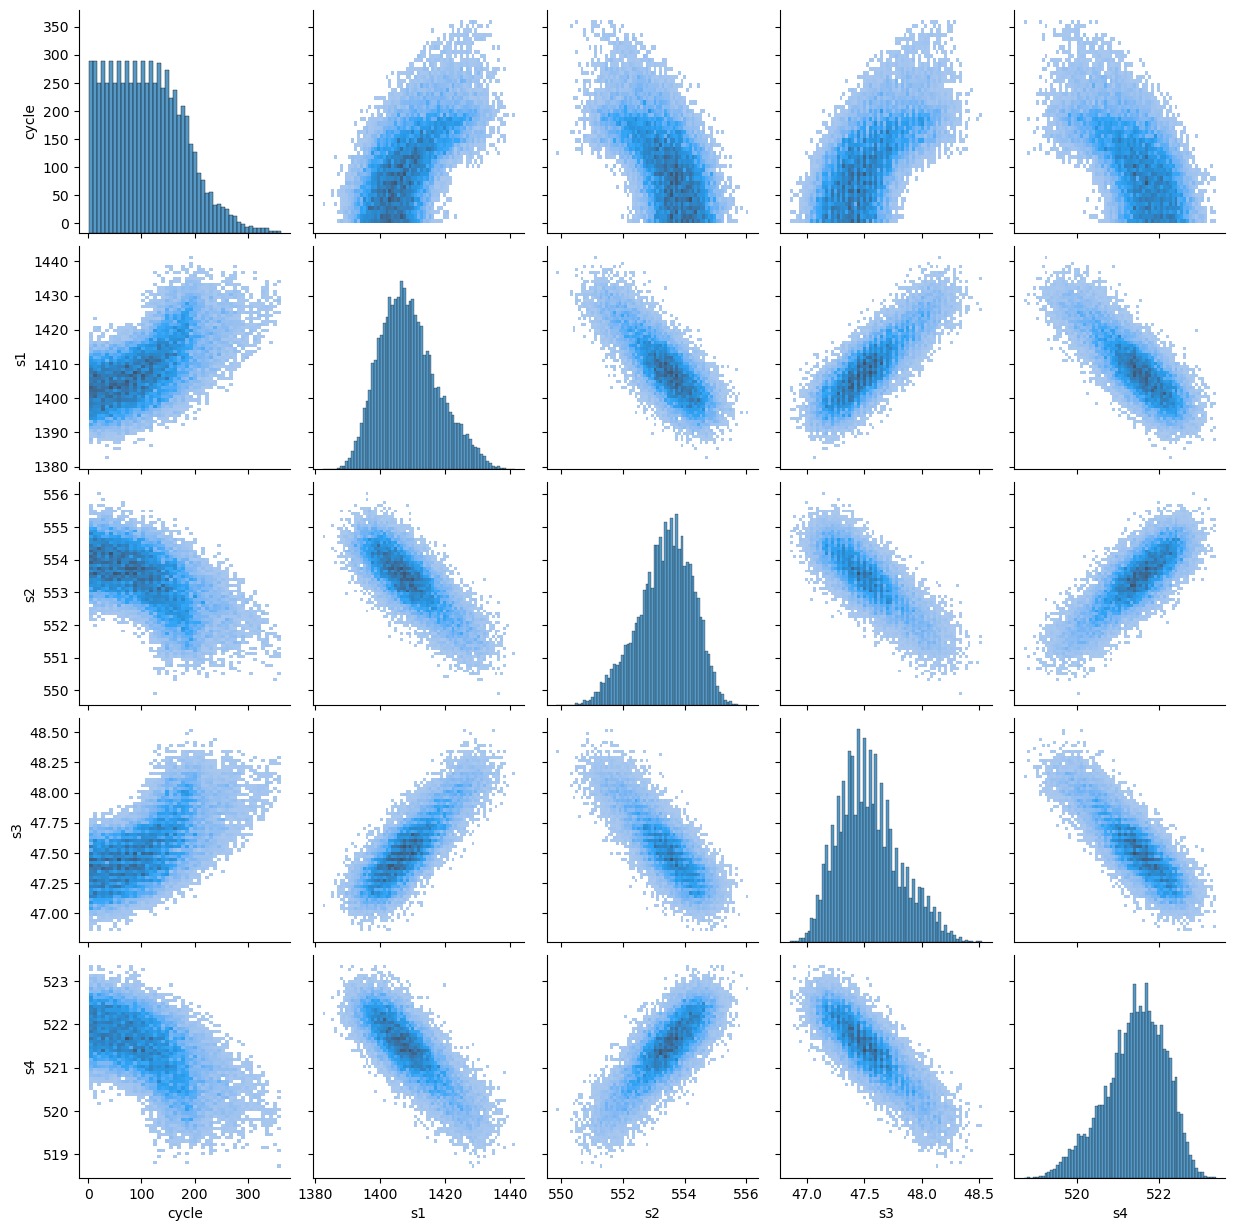

In [3]:
# Add Pair Plot
sns.pairplot(data = X_train, kind = "hist")
plt.show()

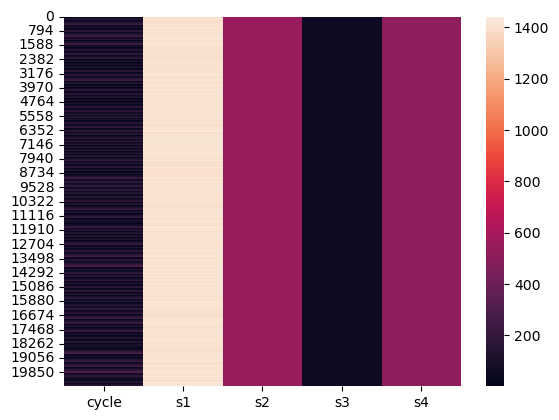

In [4]:
# Heatmap
sns.heatmap(data = X_train)
plt.show()

In [5]:
ClassBalance1=pd.read_csv('Data/test_selected_ttf.csv')['label_bnc'].value_counts()
# This shows class inbalance, accuracy shouldn't be your model metric
ClassBalance2=pd.read_csv('Data/train_selected.csv')['label_bnc'].value_counts()
print(ClassBalance2)

0    17531
1     3100
Name: label_bnc, dtype: int64


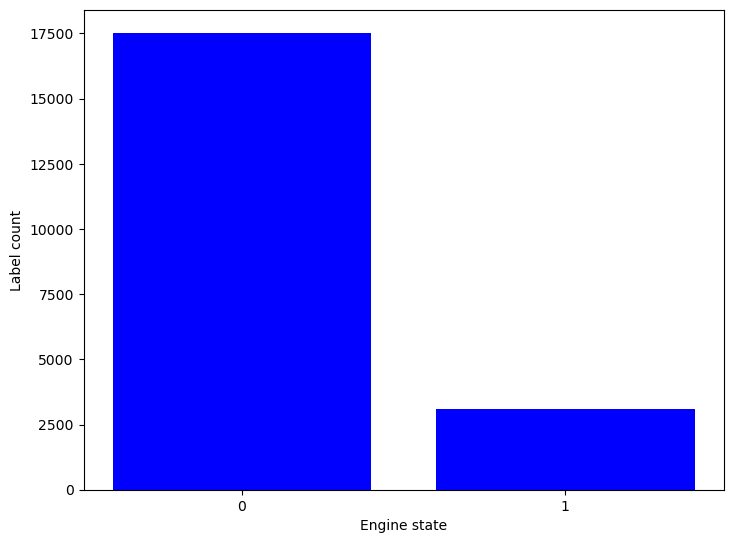

In [6]:
fig1=plt.figure()
ax=fig1.add_axes([0,0,1,1])
labels=['0','1']
label_count=[ClassBalance2[0],ClassBalance2[1]]
ax.bar(labels,label_count, color = 'blue')
ax.set_ylabel('Label count')
ax.set_xlabel('Engine state')
plt.show()

## Logistic Regression

In [17]:
# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

In [18]:
# Create the classifier: logreg
logreg = LogisticRegression(max_iter=100)

In [19]:
logreg_cv = GridSearchCV(logreg, param_grid, cv=10)

In [20]:
# Fit the classifier to the GridSearched LogReg
logreg_cv.fit(X_train,y_train)

c:\Users\DJGue\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08])})

In [23]:
# Predict the labels of the test set with Grid Searched LogReg
logreg_CV_pred = logreg_cv.predict(X_test)

# Compute predicted probabilities: logreg_CV_pred_prob
logreg_CV_pred_prob = logreg_cv.predict_proba(X_test)[:,1]

In [24]:
# Compute and print the CV confusion matrix and CV classification report
print(confusion_matrix(y_test, logreg_CV_pred))
print(classification_report(y_test, logreg_CV_pred))

print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

[[73  2]
 [ 8 17]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.94        75
           1       0.89      0.68      0.77        25

    accuracy                           0.90       100
   macro avg       0.90      0.83      0.85       100
weighted avg       0.90      0.90      0.90       100

Tuned Logistic Regression Parameters: {'C': 19306.977288832535}
Best score is 0.9445491250418033


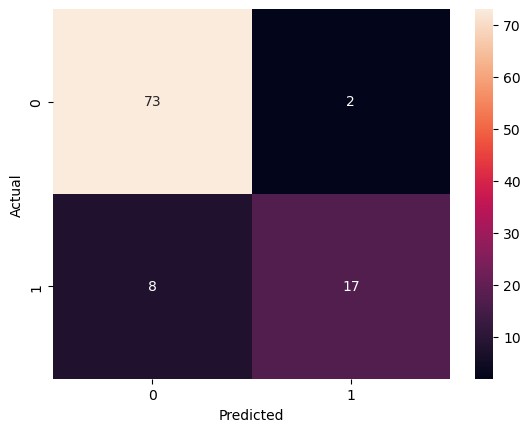

In [25]:
logreg_cv_data = pd.DataFrame(y_test, columns=['y_Actual'])
df = logreg_cv_data.assign(y_Predicted = logreg_CV_pred)
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

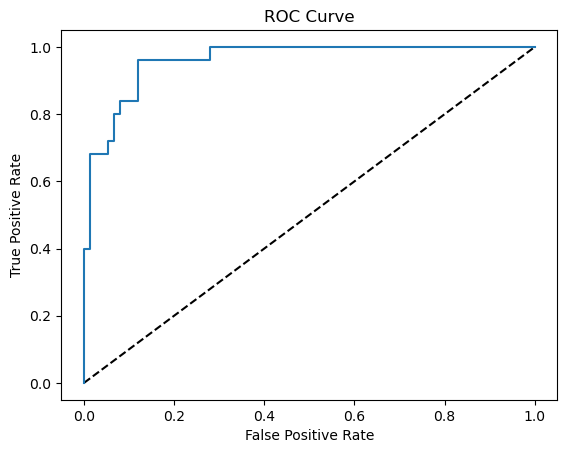

In [26]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, logreg_CV_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [27]:
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, logreg_CV_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(logreg, X_train, y_train, cv=10, scoring = 'roc_auc')

# Print list of AUC scores
print("Average AUC scores computed using 10-fold cross-validation: {}".format(np.mean(cv_auc)))

AUC: 0.96
Average AUC scores computed using 10-fold cross-validation: 0.9798578787456531


## Support Vector Classifier

In [48]:
from sklearn.svm import SVC

In [50]:
# Setup the hyperparameter grid
# c_space = np.logspace(0, 5, 15)
# param_grid = {'C': [0,1,2,3,4,5]}
param_grid = {'C': [1,5,10]}

In [51]:
# Instantiate the SVC classifier: clf
SVC = SVC(probability=True)

In [52]:
SVC_CV=GridSearchCV(SVC,param_grid,cv=5)

In [53]:
# Fit the SVC to the train set
SVC_CV.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [1, 5, 10]})

In [54]:
# Predict the labels of the test set
SVC_CV_pred = SVC_CV.predict(X_test)
# Compute predicted probabilities: logreg_CV_pred_prob
SVC_CV_pred_prob = SVC_CV.predict_proba(X_test)[:,1]

In [55]:
# Compute metrics
#print(confusion_matrix(y_test, SVC_CV_pred))
print(classification_report(y_test, SVC_CV_pred))

print("Tuned Logistic Regression Parameters: {}".format(SVC_CV.best_params_)) 
print("Best score is {}".format(SVC_CV.best_score_))

              precision    recall  f1-score   support

           0       0.85      0.99      0.91        75
           1       0.92      0.48      0.63        25

    accuracy                           0.86       100
   macro avg       0.89      0.73      0.77       100
weighted avg       0.87      0.86      0.84       100

Tuned Logistic Regression Parameters: {'C': 10}
Best score is 0.9260330248962856


In [56]:
print(precision_score(y_test, SVC_CV_pred))
print(recall_score(y_test, SVC_CV_pred))
print(f1_score(y_test, SVC_CV_pred))

0.9230769230769231
0.48
0.631578947368421


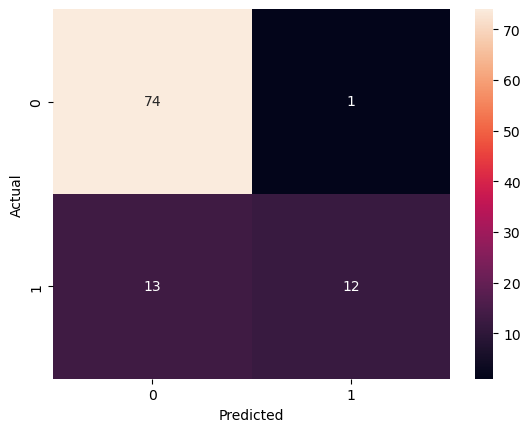

In [57]:
SVC_CV_data = pd.DataFrame(y_test, columns=['y_Actual'])
df = SVC_CV_data.assign(y_Predicted = SVC_CV_pred)
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
#ig, ax = plt.subplots(figsize=(5,4))   
sns.heatmap(confusion_matrix, annot=True)
plt.show()

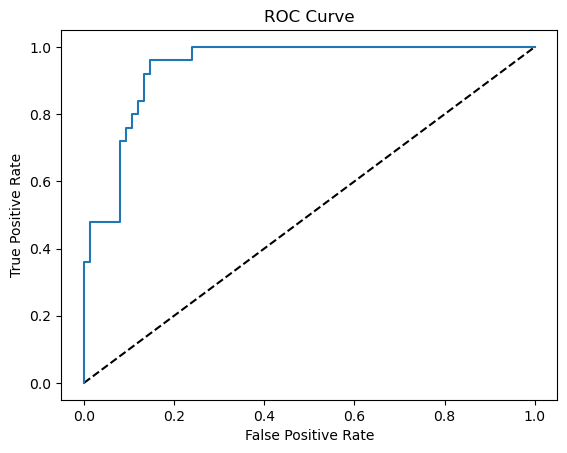

In [58]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, SVC_CV_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [59]:
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, SVC_CV_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(SVC_CV, X_train, y_train, cv=10, scoring = 'roc_auc')

# Print list of AUC scores
print("Average AUC scores computed using 10-fold cross-validation: {}".form at(np.mean(cv_auc)))

AUC: 0.9402666666666667
Average AUC scores computed using 10-fold cross-validation: 0.9683942056380717


## K - Nearest Neighbors

In [ ]:
# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier 

In [ ]:
parameters = {'n_neighbors':[0,1,2,3,4,5,6,7,8,9,10]}

In [ ]:
# Create a k-NN classifier with 6 neighbors: knn
# knn = KNeighborsClassifier(n_neighbors=6)
knn = KNeighborsClassifier()

In [ ]:
knn_CV=GridSearchCV(knn,parameters,cv=10)

In [ ]:
# Fit the classifier to the data
knn_CV.fit(X_train,y_train)

In [ ]:
# Predict the labels of the test set
knn_CV_pred = knn_CV.predict(X_test)
# Compute predicted probabilities: y_pred_prob
knn_CV_pred_prob = knn_CV.predict_proba(X_test)[:,1]

In [ ]:
print(knn_CV.score(X_test, y_test))
print(classification_report(y_test, knn_CV_pred))

In [ ]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, knn_CV_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
knn_data = pd.DataFrame(y_test, columns=['y_Actual']).assign(y_Predicted = knn_CV_pred)
confusion_matrix = pd.crosstab(knn_data['y_Actual'], knn_data['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, knn_CV_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(knn_CV, X_train, y_train, cv=10, scoring = 'roc_auc')

# Print list of AUC scores
print("Average AUC scores computed using 10-fold cross-validation: {}".format(np.mean(cv_auc)))

## Decision Tree

In [ ]:
# Import necessary modules
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [0,1,2,3,4,5],
              "max_features": ['auto'],
              "min_samples_leaf": (1, 9),
              "criterion": ["gini", "entropy"]}

In [ ]:
# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

In [ ]:
# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = GridSearchCV(tree, param_dist, cv=10)

In [ ]:
# Fit it to the data
tree_cv.fit(X_train,y_train)
# Predict the labels of the test set
tree_cv_pred = tree_cv.predict(X_test)
# Compute predicted probabilities: y_pred_prob
tree_cv_pred_prob = tree_cv.predict_proba(X_test)[:,1]
# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

In [ ]:
print(tree_cv.score(X_test, tree_cv_pred))
print(classification_report(y_test, tree_cv_pred))

In [ ]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, tree_cv_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
tree_cv_data = pd.DataFrame(y_test, columns=['y_Actual']).assign(y_Predicted = tree_cv_pred)
confusion_matrix = pd.crosstab(tree_cv_data['y_Actual'], tree_cv_data['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, tree_cv_pred_prob)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(tree_cv, X_train, y_train, cv=10, scoring = 'roc_auc')

# Print list of AUC scores
print("Average AUC scores computed using 10-fold cross-validation: {}".format(np.mean(cv_auc)))